# Feature Engineering - Image Processing

## 1. Modules and Libraries

In [1]:
import os
import glob
from natsort import natsorted

import numpy as np
import pandas as pd
import imagehash
import cv2

from PIL import Image
from matplotlib import pyplot as plt


## 2. Image Processing

1. Process the image using contours and canny detection
2. Create perceptual image hash
3. Calculate the hash similarity

In [2]:
class ImageProcessing:
    """Generate hash similarity"""
    
    def __init__(self, source_images, dest_images, size=1024, hash_size=8, threshold=0.9):
        """
        Initialize the arguments
        Args:
            source_images (list): /path/to/the/images
            dest_images (list): /path/to/the/images
            size (int): resize dimensions
            hash_size (int): size of the perceptual hash
            threshold (float): calculate has on images with 0.9 similarity only
        """
        self.source_images = source_images
        self.dest_images = dest_images

        self.size = size
        self.hash_size = hash_size
        self.threshold = threshold
        
        self.source_hashes = []
        self.dest_hashes = []
    
    def resize_image(self, image):
        """
        Resize the image (1024*1024)
        Args:
            image (array): image that needs to be resized
        
        Returns:
            array: resized image
        """
        h, w = image.shape[:2]
        
        if h > w:
            new_h = self.size
            new_w = int(w * (self.size / h))
        else:
            new_w = self.size
            new_h = int(h * (self.size / w))
            
        return cv2.resize(image, (new_w, new_h))
    
    @staticmethod
    def add_border(image, border_size=10, value=[255, 255, 255]):
        """
        Add border for easy identification of contours
        Args:
            image (array): image that needs to be resized
            border_size (int): number of pixels to be extended on all sides
        
        Returns:
            array: image with white border
        """
        return cv2.copyMakeBorder(image, 
                                  border_size, 
                                  border_size, 
                                  border_size, 
                                  border_size, 
                                  cv2.BORDER_CONSTANT, 
                                  value=value)

        
    def find_largest_contour_image(self, image_path):
        """
        Eliminate the noise and crop the image
        Args:
            image_path (str): /path/to/the/image
        
        Return:
            array: image with largest contour 
        """
        
        # Read, resize to 1024*1024, add the white border and grayscale
        img = cv2.imread(image_path)
        img = self.resize_image(img)
        img_with_border = self.add_border(img)
        gray_img = cv2.cvtColor(img_with_border, cv2.COLOR_BGR2GRAY)

        # Create a black and white mask of the object using canny edge detection
        edges = cv2.Canny(gray_img, 30, 100)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Create a mask for the largest object and apply the mask to the original image
        mask = np.zeros_like(gray_img)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        masked_img = cv2.bitwise_and(img_with_border, img_with_border, mask=mask)

        # Crop the image to the bounding box of the largest object
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_img = masked_img[y:y+h, x:x+w]

        return cropped_img

    def compute_hash(self, image):
        """
        Compute perceptual hash of the image (64 bits)
        Args:
            image (array): image whose hash needs to be calculated
        
        Return:
            ImageHash: perceptual hash of the image
        """
        
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        return imagehash.phash(pil_image, hash_size=self.hash_size)
    
    @staticmethod
    def hamming_distance(hash1, hash2):
        """
        Compute the Hamming distance between two hashes
        Args:
            hash1 (str): 64 bit hash of the first image
            hash2 (str): 64 bit hash of the second image
        
        Returns:
            int: hamming distance between the images
        """
        return bin(int(str(hash1), 16) ^ int(str(hash2), 16)).count('1')

    def compute_image_similarity(self, source_hashes=None, dest_hashes=None):
        """
        Compute the similarity between the product images
        Args:
            source_hashes (list): hashes of the source product images
            dest_hashes (list): hashes of the dest product images
        
        Returns:
            int: overall similarity between the source and dest product images
        """
        
        if not source_hashes:
            source_hashes = self.source_hashes
        
        if not dest_hashes:
            dest_hashes = self.dest_hashes
            
        overall_similarity = 0

        for hash1 in source_hashes:
            most_similar_similarity = 0

            for hash2 in dest_hashes:
                distance = ImageProcessing.hamming_distance(hash1, hash2)
                similarity = 1 - (distance / 64.0)  

                if similarity > most_similar_similarity:
                    most_similar_similarity = similarity

            if most_similar_similarity > self.threshold:
                overall_similarity += most_similar_similarity

        return overall_similarity
    
    def preprocess_and_compute_hash(self):
        """
        Driver code to find largest contour, compute perceptual hash and overall similarity
        """
        for img in self.source_images:
            try:
                contour_img = self.find_largest_contour_image(img)
                hash_value = self.compute_hash(contour_img)
                self.source_hashes.append(str(hash_value))
            except:
                continue
        
        for img in self.dest_images:
            try:
                contour_img = self.find_largest_contour_image(img)
                hash_value = self.compute_hash(contour_img)
                self.dest_hashes.append(str(hash_value))
            except:
                continue
        
        return self.compute_image_similarity(self.source_hashes, self.dest_hashes)
    

In [3]:
def get_files_in_subdirectories(root_dir):
    """
    List all the files and subdirectories from the path
    Arg:
        root_dir (str): /path/to/the/dir
    
    Returns:
        list: reports all the file names
    """
    
    sub_dirs = natsorted([
        os.path.join(root_dir, d) 
        for d in os.listdir(root_dir) 
        if os.path.isdir(os.path.join(root_dir, d))
    ])

    img_paths = [
        natsorted([os.path.join(sub_dir, f) for f in os.listdir(sub_dir)])
        for sub_dir in sub_dirs
    ]
        
    return img_paths


In [4]:
# scraped image directories and source destination names
promapen_train = "images/ProMapEn/train"
promapen_test = "images/ProMapEn/test"

source = "walmart"
dest = "amazon"

# load all the file names to process the images
source_train_imgs = get_files_in_subdirectories(f"{promapen_train}/{source}")
dest_train_imgs = get_files_in_subdirectories(f"{promapen_train}/{dest}")

source_test_imgs = get_files_in_subdirectories(f"{promapen_test}/{source}")
dest_test_imgs = get_files_in_subdirectories(f"{promapen_test}/{dest}")


### Train set feature extraction

In [5]:
# threshold values are set as per the research paper
threshold = 0.9
hash_similarity_train = []

for src_img, dest_img in zip(source_train_imgs, dest_train_imgs):
    img = ImageProcessing(source_images=src_img, dest_images=dest_img, threshold=threshold)
    hash_similarity_train.append(img.preprocess_and_compute_hash())


### Test set feature extraction

In [6]:
# threshold values are set as per the research paper
threshold = 0.9
hash_similarity_test = []

for src_img, dest_img in zip(source_test_imgs, dest_test_imgs):
    img = ImageProcessing(source_images=src_img, dest_images=dest_img, threshold=threshold)
    hash_similarity_test.append(img.preprocess_and_compute_hash())


In [7]:
df_train = pd.DataFrame({'hash_similarity': hash_similarity_train})
df_test = pd.DataFrame({'hash_similarity': hash_similarity_test})

processed_path = "features/ProMapEn"
os.makedirs(processed_path, exist_ok=True)

df_train.to_csv(f"{processed_path}/train_similarties.csv", index=False)
df_test.to_csv(f"{processed_path}/test_similarties.csv", index=False)

## 3. Demo: Image Processing

### Part 1: Processing

In [8]:
demo_source_path = ['images/ProMapEn/train/walmart/464/0.jpeg']
demo_dest_path = ['images/ProMapEn/train/amazon/464/0.jpeg']

(-0.5, 303.5, 186.5, -0.5)

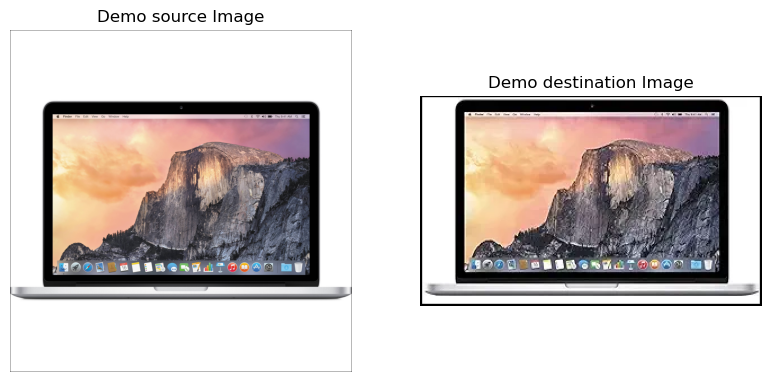

In [9]:
# Plot the images using plt
plt.figure(figsize=(15, 5))

demo_src = ImageProcessing.add_border(cv2.imread(demo_source_path[0]), border_size=2, value=[0,0,0])
demo_des = ImageProcessing.add_border(cv2.imread(demo_dest_path[0]), border_size=2, value=[0,0,0])

# Plot the first image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(demo_src, cv2.COLOR_BGR2RGB))
plt.title('Demo source Image')
plt.axis('off')

# Plot the second image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(demo_des, cv2.COLOR_BGR2RGB))
plt.title('Demo destination Image')
plt.axis('off')

In [10]:
img = ImageProcessing(source_images=demo_source_path, dest_images=demo_dest_path, threshold=0.9)

In [11]:
demo_src_processed = img.find_largest_contour_image(img.source_images[0])
demo_des_processed = img.find_largest_contour_image(img.dest_images[0])

(-0.5, 830.5, 562.5, -0.5)

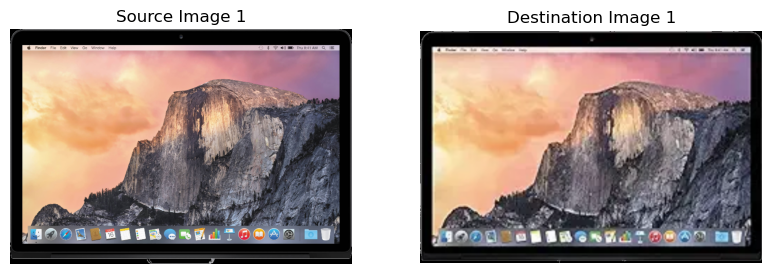

In [12]:
# Plot the images using plt
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(demo_src_processed, cv2.COLOR_BGR2RGB))
plt.title('Source Image 1')
plt.axis('off')

# Plot the third image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(demo_des_processed, cv2.COLOR_BGR2RGB))
plt.title('Destination Image 1')
plt.axis('off')

### Part 2: Image hash creation

In [13]:
demo_src_hash = img.compute_hash(image=demo_src_processed)
demo_des_hash = img.compute_hash(image=demo_des_processed)

print(f"Perceptual hash of the SRC image: {demo_src_hash}")
print(f"Perceptual hash of the DST image: {demo_des_hash}")


Perceptual hash of the SRC image: d0c40f381b1f7a67
Perceptual hash of the DST image: d0c40f791b1f6a27


### Part 3: Image hashes similarity computation

In [14]:
# Compute overall image similarity
hash_similar = img.compute_image_similarity([demo_src_hash], [demo_des_hash])

print(f"Overall Image Similarity (hash_similarity): {hash_similar}")


Overall Image Similarity (hash_similarity): 0.9375
